## Object Detection with YOLOV3

### Inspecting the images

Let's take a look at the images that will be passed to the YOLOV3 model. This will bring insight on what type of common objects are present for detection. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset.

In [10]:
from IPython.display import Image, display


Displaying image: apple.jpg


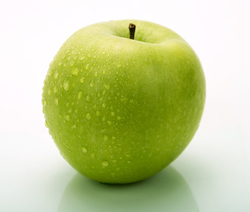


Displaying image: clock.jpg


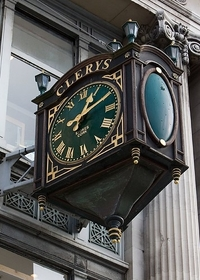


Displaying image: oranges.jpg


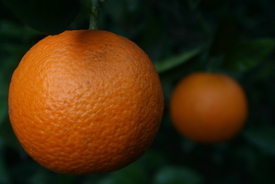


Displaying image: car.jpg


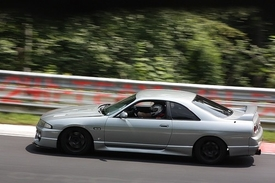

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Creating the detect_and_draw_box function

Before using the object detection model, create a directory where you can store the resulting images:


In [6]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [7]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.571720540523529



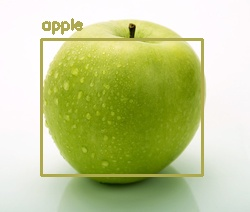

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



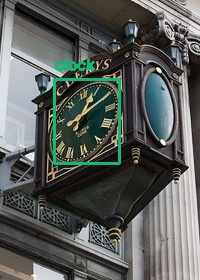

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590624809265

Detected object: orange with confidence level of 0.5561691522598267



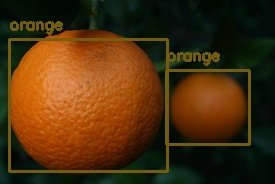

Image processed: car.jpg

Detected object: car with confidence level of 0.6325409412384033



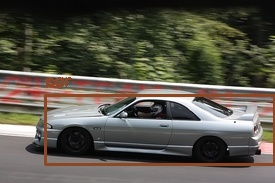

In [6]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081



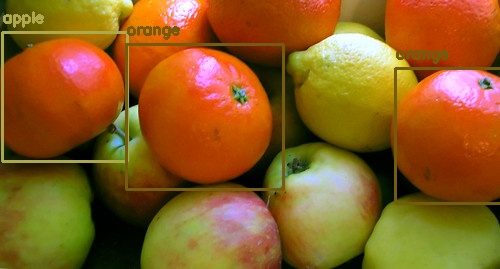

In [7]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple.

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818483829498291

Detected object: orange with confidence level of 0.5346482992172241

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.34759876132011414

Detected object: orange with confidence level of 0.32876095175743103

Detected object: apple with confidence level of 0.31244680285453796

Detected object: orange with confidence level of 0.2798606753349304

Detected object: orange with confidence level of 0.2749978303909302

Detected object: apple with confidence level of 0.2744506895542145

Detected object: orange with confidence level of 0.21419063210487366



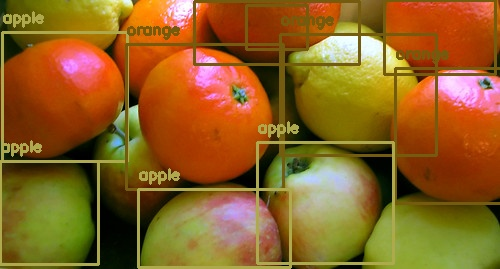

In [8]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level the model successfully detects most of the fruits.

## Deploying the model using fastAPI


### Placing your object detection model in a server

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Before diving into deployment, let's quickly recap some important concepts and how they translate to `fastAPI`. Let's also create a directory to store the images that are uploaded to the server.


In [9]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [2]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [11]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model,confidence_level:float, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model, confidence=confidence_level)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server!

In [12]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [21364]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:50741 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50741 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:50742 - "POST /predict?model=yolov3-tiny&confidence_level=0.2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51022 - "POST /predict?model=yolov3-tiny&confidence_level=0.7 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51025 - "POST /predict?model=yolov3-tiny&confidence_level=0.7 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51028 - "POST /predict?model=yolov3-tiny&confidence_level=0.7 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51030 - "POST /predict?model=yolov3-tiny&confidence_level=0.7 HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [21364]


The server is now running! Head over to [http://localhost:8000/](http://localhost:8000/) to see it in action.

**Try submitting an image** and see how API is able to detect objects within it and return a new image containing the bounding boxes alongside the labels of the detected objects. **Visit [http://localhost:8000/docs](http://localhost:8000/docs) to open fastAPI's built-in client.** 

